# Курсовой проект "Python для Data Sciance"

### Материалы к проекту (файлы):
train.csv, test.csv
### Задание:
Используя данные из train.csv, построить модель для предсказания цен на недвижимость (квартиры). С помощью полученной модели предсказать цены для квартир из файла test.csv.
### Целевая переменная:
Price
### Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)
### Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"), разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

## Подключение библиотек и скриптов

In [2432]:
import pandas as pd
import numpy as np
import random 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

In [2433]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2434]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Прогнозируемые значения')
    plt.ylabel('Истиные значения')
    plt.title('Прогнозирование обучающей выборки')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Прогнозируемые значения')
    plt.ylabel('Истиные значения')
    plt.title('Прогнозирование тестовой выборки')

    plt.show()
    

### Пути к директориям и файлам и загрузка данных

In [2435]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'
PREDICTIONS_PATH = 'predictions.csv '

train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

### Разбор обучающего датасета

In [2436]:
# Размерность датасета 
train_df.shape

(10000, 20)

In [2437]:
# Просмотр первых и последних значений датасета
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [2438]:
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808
9999,6306,128,1.0,38.666645,21.157874,8.0,7,17.0,1990,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.077615


#### Комментарий
Обучающий датасет имеет 10 000 значений и 20 факторов (признаков).
При просмотре значений замечаем отсутствие значений фактора LifeSquare, Healthcare_1 и нулевые значения Ecology_1

In [2439]:
# Заполненность и типы данных факторов
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

### Описание датасета :
    Id - идентификационный номер квартиры
    DistrictId - идентификационный номер района
    Rooms - количество комнат
    Square - площадь
    LifeSquare - жилая площадь
    KitchenSquare - площадь кухни
    Floor - этаж
    HouseFloor - количество этажей в доме
    HouseYear - год постройки дома
    Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
    Social_1, Social_2, Social_3 - социальные показатели местности
    Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
    Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
    Price - цена квартиры

### Продолжаем исследование датасета
Рассмотрим графики распределения цены и количественные переменные

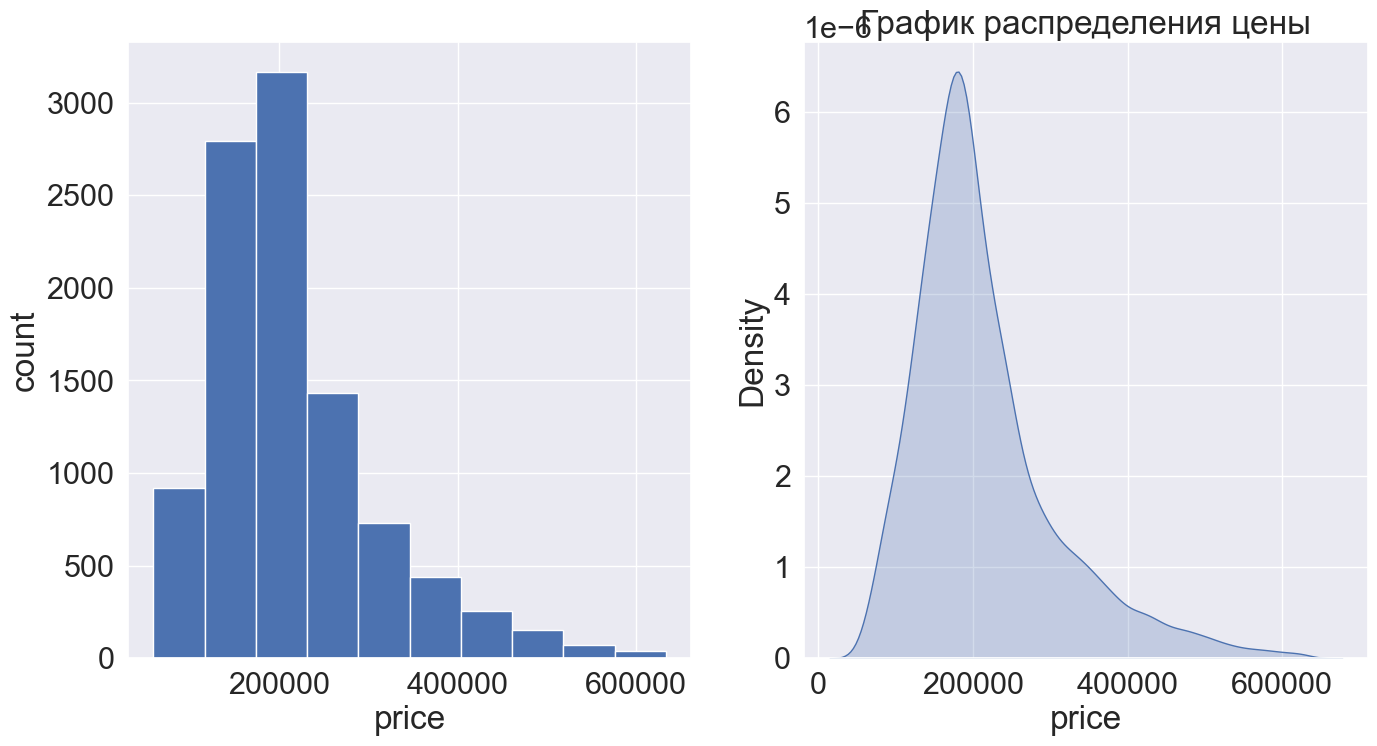

In [2440]:
plt.figure(figsize= (16, 8)) #создаю область заданного размера

plt.subplot(121) #в сетке размещаем первый график (кол-во строк, кол-во столбцов, порядковый номер)
train_df['Price'].hist()
plt.ylabel('count')
plt.xlabel('price')

plt.subplot(122) #в сетке размещаем второй график
sns.kdeplot(train_df['Price'], shade = True, legend = False)
plt.xlabel('price')

plt.title('График распределения цены')
plt.show()

In [2441]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [2442]:
# Приведем факторы Id и District к строковому типу
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)
# Определяем номинативные переменные
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [2443]:
# Рассмотрим значения номинативных переменных (Id меняется от 1 до 10 000)
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
207      1
117      1
174      1
205      1
209      1
Name: DistrictId, Length: 205, dtype: int64

In [2444]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [2445]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [2446]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

### Обработка выбросов

In [2447]:
# Определяем "аномальные" значения
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [2448]:
rooms_med = train_df['Rooms'].median() # Определяем медианное значение
train_df.loc[train_df['Rooms'].isin([0, 6, 10, 19]), 'Rooms'] = rooms_med # Подставляем вместо аномальных значений
rooms_med

2.0

In [2449]:
# Проверяем результат работы с выбросом
train_df['Rooms'].value_counts()

2.0    3892
1.0    3705
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

In [2450]:
train_df['HouseYear'].value_counts().sort_index(ascending=True)

1910          1
1912          2
1914          1
1916          1
1917          3
           ... 
2018        175
2019         79
2020         19
4968          1
20052011      1
Name: HouseYear, Length: 97, dtype: int64

In [2451]:
train_df.loc[train_df['HouseYear'].isin([4968]), 'HouseYear'] = 1968
train_df.loc[train_df['HouseYear'].isin([20052011]), 'HouseYear'] = 2011

#### На всех ресурсах площадь квартир ограничивается двумя знаками после запятой - поэтому приведу значения площади к данному виду

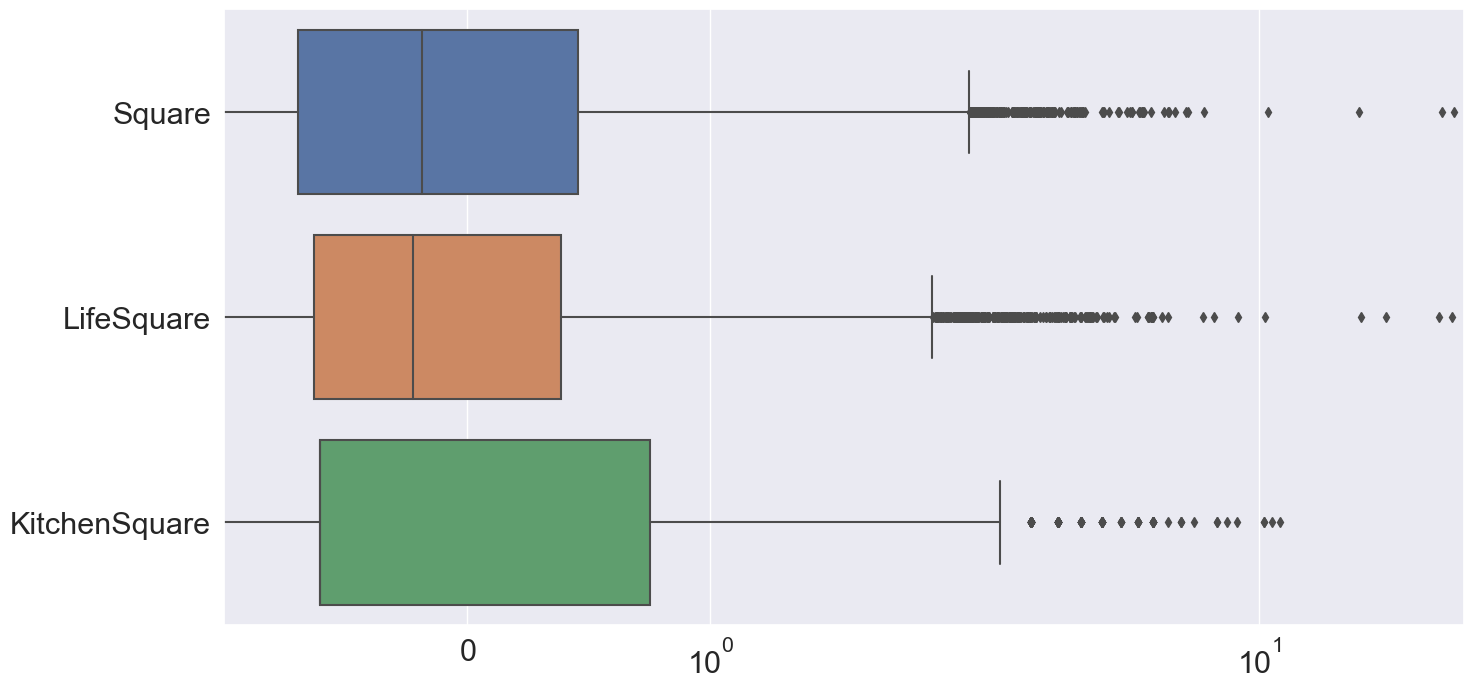

In [2452]:
# Смотрим выбросы по площади
plt.figure(figsize=(16, 8))
sns.boxplot(data=df[['Square', 'LifeSquare', 'KitchenSquare']], orient='h')
plt.xscale('symlog')
plt.xlim(left=-1)
plt.show()

In [2453]:
# Определим медианные значения и проставим их в пропусках и аномально низких и высоких значениях
kitchsq_med = train_df['KitchenSquare'].median() # 6.0
hfloor_med = train_df['HouseFloor'].median() # 13.0
square_med = train_df['Square'].median()

train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = hfloor_med
# Сравним и проработаем значения площадей
train_df.loc[train_df['Square'] < 20, 'Square'] = square_med

train_df.loc[train_df['KitchenSquare'] <= 4, 'KitchenSquare'] = kitchsq_med
train_df.loc[train_df['KitchenSquare'] > 40, 'KitchenSquare'] = kitchsq_med
train_df.loc[train_df['KitchenSquare'] * 1.5 >= train_df['LifeSquare'], 'KitchenSquare'] = kitchsq_med

LifeSquare_mod = train_df[train_df['LifeSquare'] < 15] 
LifeSquare_mod['LifeSquare'] = LifeSquare_mod['Square'] - LifeSquare_mod['KitchenSquare']
train_df.loc[train_df['LifeSquare'] < 15, 'LifeSquare'] = LifeSquare_mod['LifeSquare']

LifeSquare_mod = train_df[train_df['LifeSquare'] > 650] 
LifeSquare_mod['LifeSquare'] = LifeSquare_mod['Square'] - LifeSquare_mod['KitchenSquare']
train_df.loc[train_df['LifeSquare'] > 650, 'LifeSquare'] = LifeSquare_mod['LifeSquare']

LifeSquare_mod = train_df[train_df['LifeSquare'].isnull()] 
LifeSquare_mod['LifeSquare'] = LifeSquare_mod['Square'] - LifeSquare_mod['KitchenSquare']
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] = LifeSquare_mod['LifeSquare']

In [2454]:
train_df['Square'].astype(str).str.extract(r'(\d+\.\d{2})')
train_df['Square'].floordiv(0.01).div(100)
train_df['Square'] = train_df['Square']//0.01/100

train_df['LifeSquare'].astype(str).str.extract(r'(\d+\.\d{2})')
train_df['LifeSquare'].floordiv(0.01).div(100)
train_df['LifeSquare'] = train_df['LifeSquare']//0.01/100

Исключаем фактор с 50% пропущенных значений

In [2455]:
train_df.drop('Healthcare_1', axis=1, inplace=True)

### Построение новых признаков

In [2456]:
train_df['Ecology_2_bin'] = train_df['Ecology_2'].replace({'A':0, 'B':1})
train_df['Ecology_3_bin'] = train_df['Ecology_3'].replace({'A':0, 'B':1})
train_df['Shops_2_bin'] = train_df['Shops_2'].replace({'A':0, 'B':1})

In [2457]:
train_df['m_2_Price'] = train_df['Price'] / train_df['Square']

In [2458]:
m_2_MedPriceByDistrict = train_df.groupby(['DistrictId'], as_index=False).agg({'m_2_Price':'median'})\
                    .rename(columns={'m_2_Price':'m_2_MedPriceByDistrict'})
m_2_MedPriceByHouseYear = train_df.groupby(['HouseYear'], as_index=False).agg({'m_2_Price':'median'})\
                    .rename(columns={'m_2_Price':'m_2_MedPriceByHouseYear'})

Добавляем новые признаки к датасету

In [2459]:
train_df = train_df.merge(m_2_MedPriceByDistrict, on=['DistrictId'], how='left')
train_df = train_df.merge(m_2_MedPriceByHouseYear, on=['HouseYear'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,m_2_Price,m_2_MedPriceByDistrict,m_2_MedPriceByHouseYear
0,14038,35,2.0,47.98,29.44,6.0,7,9.0,1969,0.089040,...,0,11,B,184966.930730,1,1,1,3855.084009,4358.670524,4473.989527
1,15053,41,3.0,65.68,40.04,8.0,7,9.0,1978,0.000070,...,1,16,B,300009.450063,1,1,1,4567.744368,4437.548039,4318.140762
2,4765,53,2.0,44.94,29.19,6.0,8,12.0,1968,0.049637,...,1,3,B,220925.908524,1,1,1,4916.019326,4846.495850,4434.292555
3,5809,58,2.0,53.35,52.73,9.0,8,17.0,1977,0.437885,...,0,5,B,175616.227217,1,1,1,3291.775580,2950.593994,2901.403481
4,10783,99,1.0,39.64,23.77,7.0,11,12.0,1976,0.012339,...,2,4,B,150226.531644,1,1,1,3789.771232,3992.804219,4367.686148


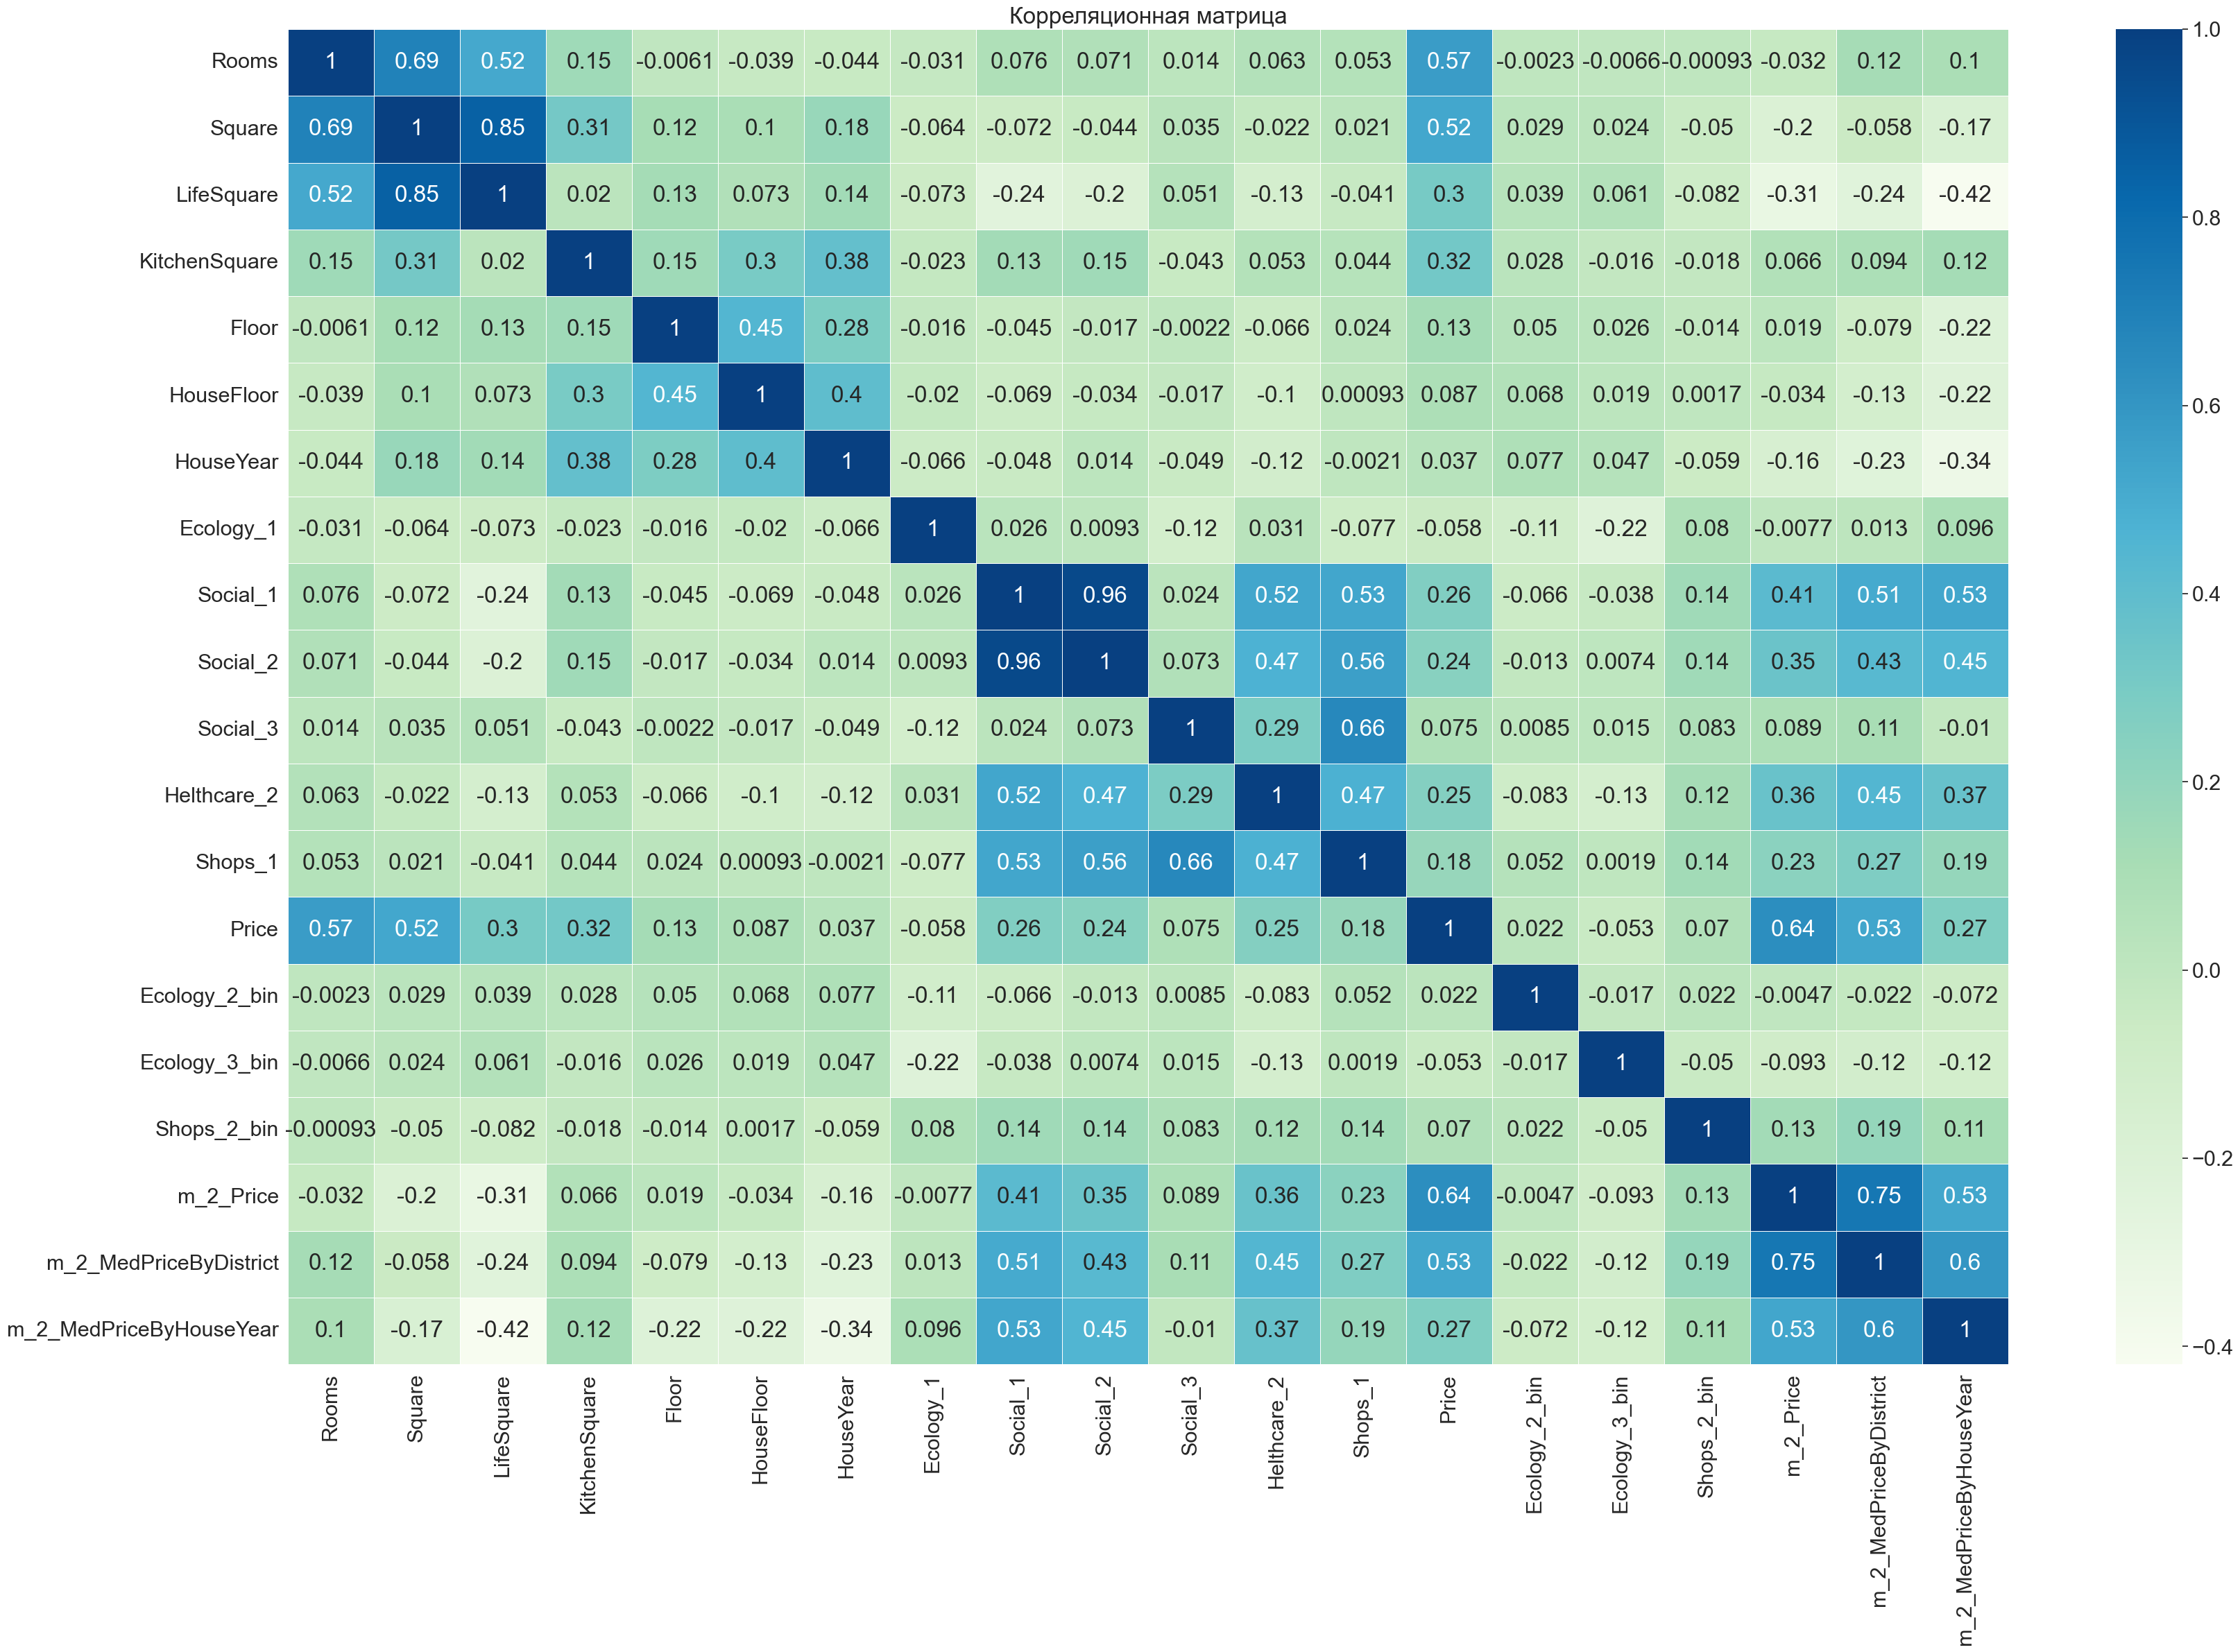

In [2460]:
plt.figure(figsize = (40,25))

sns.set(font_scale=2)
sns.heatmap(train_df.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Корреляционная матрица')
plt.show()

### Отбираем признаки для модели

In [2461]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 
                 'm_2_MedPriceByDistrict', 'm_2_MedPriceByHouseYear', 
                 'Ecology_1','Social_2', 'Social_3', 'Helthcare_2', 'Shops_1', 
                 'Ecology_2_bin', 'Ecology_3_bin', 'Shops_2_bin',]
target_name = 'Price'

In [2462]:
df = train_df[feature_names + [target_name]]
df.head(10)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,m_2_MedPriceByDistrict,m_2_MedPriceByHouseYear,Ecology_1,Social_2,Social_3,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,Price
0,2.0,47.98,29.44,6.0,7,9.0,1969,4358.670524,4473.989527,0.089040,7976,5,0,11,1,1,1,184966.930730
1,3.0,65.68,40.04,8.0,7,9.0,1978,4437.548039,4318.140762,0.000070,10309,1,1,16,1,1,1,300009.450063
2,2.0,44.94,29.19,6.0,8,12.0,1968,4846.495850,4434.292555,0.049637,7759,0,1,3,1,1,1,220925.908524
3,2.0,53.35,52.73,9.0,8,17.0,1977,2950.593994,2901.403481,0.437885,5735,3,0,5,1,1,1,175616.227217
4,1.0,39.64,23.77,7.0,11,12.0,1976,3992.804219,4367.686148,0.012339,5776,1,2,4,1,1,1,150226.531644
5,3.0,80.38,46.68,12.0,5,17.0,2011,4736.694015,3117.974160,0.309479,7715,4,0,6,1,1,1,215898.447742
6,2.0,62.25,37.16,7.0,3,5.0,1960,5446.597833,4472.198482,0.460556,4386,14,1,5,1,1,1,296021.204377
7,2.0,80.31,74.31,6.0,14,13.0,1977,3319.464742,2901.403481,0.075779,1437,3,0,2,1,1,1,221244.156664
8,2.0,64.51,58.51,6.0,9,17.0,1977,3251.749068,2901.403481,0.007122,264,0,0,1,1,1,1,229102.795999
9,1.0,46.46,18.91,8.0,13,17.0,2014,2273.693455,2793.907596,0.075779,1437,3,0,2,1,1,1,95380.220993


In [2463]:
#!!!
#scaler = StandardScaler()
#stand_features = scaler.fit_transform(df[feature_names])
stand_features = scaler.transform(train_df[feature_names])
train_df[feature_names] = pd.DataFrame(stand_features, columns=feature_names)

In [2464]:
df[feature_names] = pd.DataFrame(stand_features, columns=feature_names)
df.head(10)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,m_2_MedPriceByDistrict,m_2_MedPriceByHouseYear,Ecology_1,Social_2,Social_3,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,Price
0,0.137605,-0.402028,-0.539893,-0.604425,-0.291306,-0.614468,-0.861767,0.433555,0.910461,-0.250529,0.654880,-0.127533,-0.883480,1.408356,0.09897,0.16816,0.299864,184966.930730
1,1.370628,0.442985,-0.049775,0.299050,-0.291306,-0.614468,-0.372938,0.512622,0.705972,-0.998053,1.237169,-0.295384,-0.213923,2.448700,0.09897,0.16816,0.299864,300009.450063
2,0.137605,-0.547160,-0.551453,-0.604425,-0.100498,-0.148856,-0.916082,0.922550,0.858375,-0.581588,0.600720,-0.337347,-0.213923,-0.256195,0.09897,0.16816,0.299864,220925.908524
3,0.137605,-0.145660,0.536979,0.750788,-0.100498,0.627163,-0.427253,-0.977896,-1.152927,2.680470,0.095553,-0.211458,-0.883480,0.159943,0.09897,0.16816,0.299864,175616.227217
4,-1.095417,-0.800187,-0.802060,-0.152687,0.471924,-0.148856,-0.481567,0.066812,0.770981,-0.894969,0.105786,-0.295384,0.455633,-0.048126,0.09897,0.16816,0.299864,150226.531644
5,1.370628,1.144775,0.257242,2.106000,-0.672921,0.627163,1.419434,0.812485,-0.868765,1.601602,0.589738,-0.169496,-0.883480,0.368011,0.09897,0.16816,0.299864,215898.447742
6,0.137605,0.279234,-0.182939,-0.152687,-1.054535,-1.235283,-1.350596,1.524090,0.908111,2.870953,-0.241141,0.250131,-0.213923,0.159943,0.09897,0.16816,0.299864,296021.204377
7,0.137605,1.141433,1.534785,-0.604425,1.044346,0.006348,-0.427253,-0.608141,-1.152927,-0.361948,-0.977177,-0.211458,-0.883480,-0.464264,0.09897,0.16816,0.299864,221244.156664
8,0.137605,0.387128,0.804232,-0.604425,0.090309,0.627163,-0.427253,-0.676019,-1.152927,-0.938799,-1.269944,-0.337347,-0.883480,-0.672333,0.09897,0.16816,0.299864,229102.795999
9,-1.095417,-0.474594,-1.026774,0.299050,0.853539,0.627163,1.582377,-1.656419,-1.293972,-0.361948,-0.977177,-0.211458,-0.883480,-0.464264,0.09897,0.16816,0.299864,95380.220993


### Разбиение на train и test

In [2465]:
X = df[feature_names]
y = df[target_name]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.67, shuffle=True, random_state=42)

### Построение модели

In [2466]:
rf_model = RandomForestRegressor(random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)

RandomForestRegressor(criterion='mse', random_state=21)

Train R2:	0.967
Test R2:	0.745


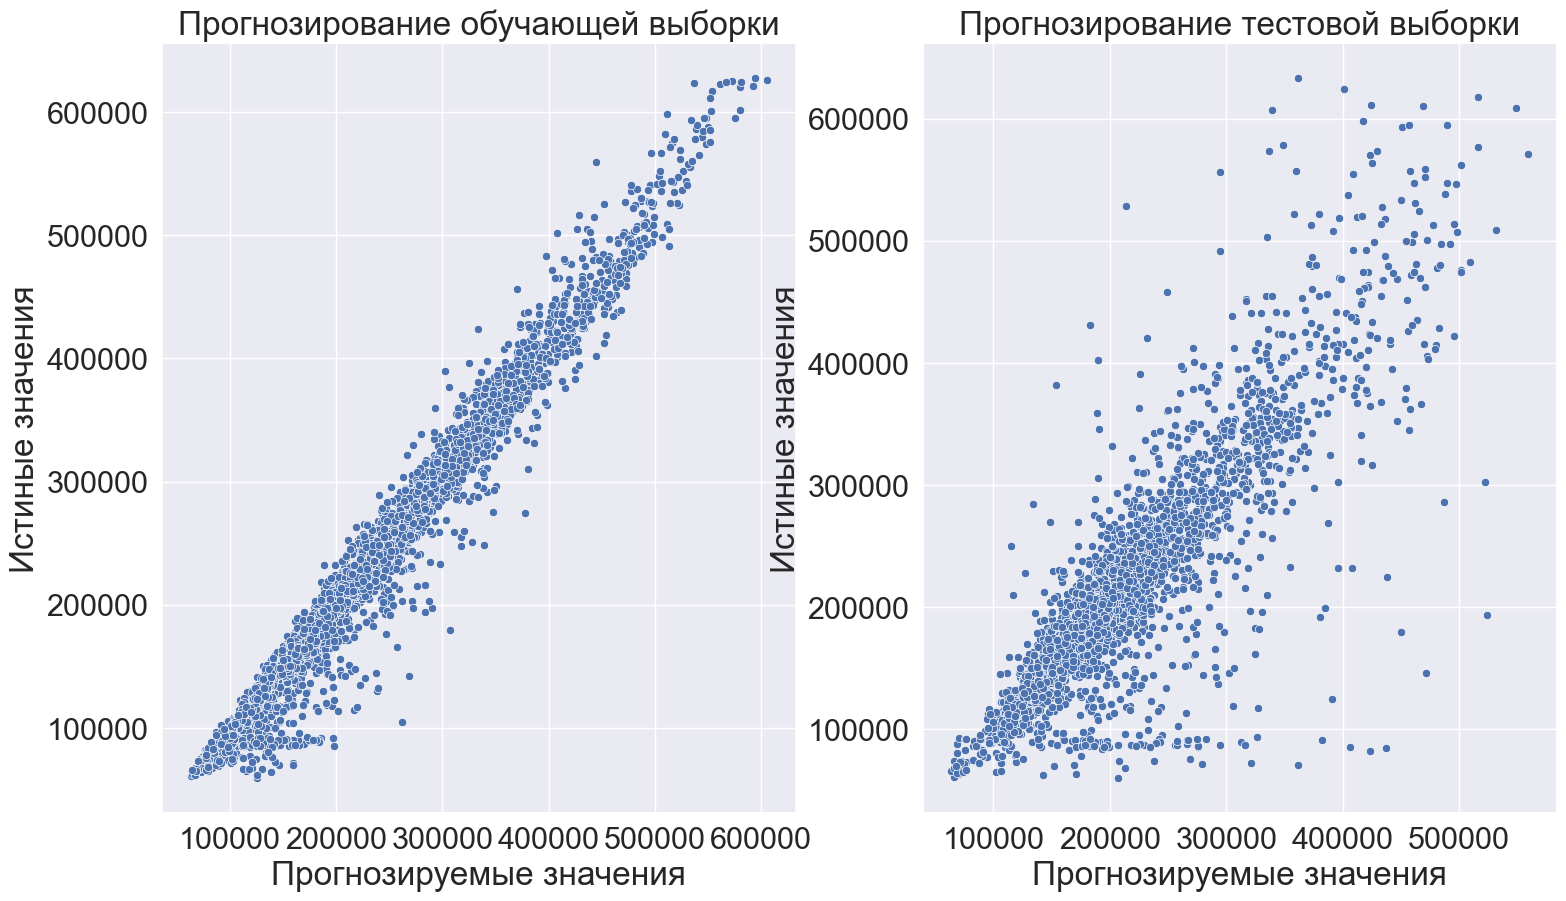

In [2467]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

### Кросс-валидация

In [2468]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.76257255, 0.71918813, 0.76437707])

In [2469]:
cv_score.mean()

0.7487125822409794

### Важность признаков

In [2470]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.418567
7,m_2_MedPriceByDistrict,0.340699
8,m_2_MedPriceByHouseYear,0.033861
2,LifeSquare,0.032173
0,Rooms,0.026053
10,Social_2,0.025387
4,Floor,0.023585
6,HouseYear,0.020440
9,Ecology_1,0.017786
5,HouseFloor,0.015514


### Прогнозирование на тестовом датасете

In [2471]:
test_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A


Смотрим размер датасета

In [2472]:
test_df.shape

(5000, 19)

Смотрим информацию датасета

In [2473]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [2474]:
test_df['Id'] = train_df['Id'].astype(str)
test_df['DistrictId'] = train_df['DistrictId'].astype(str)

In [2475]:
test_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


### Добовляем новые факторы

In [2476]:
test_df['Ecology_2_bin'] = test_df['Ecology_2'].replace({'A':0, 'B':1})
test_df['Ecology_3_bin'] = test_df['Ecology_3'].replace({'A':0, 'B':1})
test_df['Shops_2_bin'] = test_df['Shops_2'].replace({'A':0, 'B':1})

In [2477]:
test_df = test_df.merge(m_2_MedPriceByDistrict, on=['DistrictId'], how='left')
test_df = test_df.merge(m_2_MedPriceByHouseYear, on=['HouseYear'], how='left')

### Работа с пропусками и выбросами

In [2478]:
test_df = test_df.drop('Healthcare_1', axis=1)

In [2479]:
rooms_med = test_df['Rooms'].median() # Определяем медианное значение
test_df.loc[test_df['Rooms'].isin([0, 6, 10, 19]), 'Rooms'] = rooms_med # Подставляем вместо аномальных значений

In [2480]:
test_df.loc[test_df['Rooms'].isin([0, 17]), 'Rooms'] = rooms_med

In [2481]:
# Определим медианные значения и проставим их в пропусках и аномально низких и высоких значениях
kitchsq_med = test_df['KitchenSquare'].median() # 6.0
hfloor_med = test_df['HouseFloor'].median() # 13.0
square_med = test_df['Square'].median()

test_df.loc[test_df['HouseFloor'] == 0, 'HouseFloor'] = hfloor_med
# Сравним и проработаем значения площадей
test_df.loc[test_df['Square'] < 20, 'Square'] = square_med

test_df.loc[test_df['KitchenSquare'] <= 4, 'KitchenSquare'] = kitchsq_med
test_df.loc[test_df['KitchenSquare'] > 40, 'KitchenSquare'] = kitchsq_med
test_df.loc[test_df['KitchenSquare'] * 1.5 >= test_df['LifeSquare'], 'KitchenSquare'] = kitchsq_med

LifeSquare_mod = test_df[test_df['LifeSquare'] < 15] 
LifeSquare_mod['LifeSquare'] = LifeSquare_mod['Square'] - LifeSquare_mod['KitchenSquare']
test_df.loc[test_df['LifeSquare'] < 15, 'LifeSquare'] = LifeSquare_mod['LifeSquare']

LifeSquare_mod = test_df[test_df['LifeSquare'] > 650] 
LifeSquare_mod['LifeSquare'] = LifeSquare_mod['Square'] - LifeSquare_mod['KitchenSquare']
test_df.loc[test_df['LifeSquare'] > 650, 'LifeSquare'] = LifeSquare_mod['LifeSquare']

LifeSquare_mod = test_df[test_df['LifeSquare'].isnull()] 
LifeSquare_mod['LifeSquare'] = LifeSquare_mod['Square'] - LifeSquare_mod['KitchenSquare']
test_df.loc[test_df['LifeSquare'].isnull(), 'LifeSquare'] = LifeSquare_mod['LifeSquare']

In [2482]:
test_df.loc[test_df['m_2_MedPriceByHouseYear'].isnull(), 'm_2_MedPriceByHouseYear'] = test_df['m_2_MedPriceByHouseYear'].median()

In [2483]:
test_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,m_2_MedPriceByDistrict,m_2_MedPriceByHouseYear
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,1.906200,56.579496,41.218932,7.300400,8.632000,12.915400,1984.392600,0.119874,24.933800,5406.900000,8.262600,1.31940,4.242800,0.990400,0.970200,0.917600,3922.976133,3787.394416
std,0.805935,18.916206,19.096840,2.146504,5.483228,6.468617,18.573149,0.120070,17.532202,4026.614773,23.863762,1.47994,4.777365,0.097518,0.170052,0.275001,1000.935736,756.872006
min,1.000000,20.011215,14.011215,5.000000,1.000000,1.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2273.693455,2793.907596
25%,1.000000,41.977760,27.787789,6.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,2938.458934,2901.403481
50%,2.000000,52.923101,36.543826,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,1.00000,3.000000,1.000000,1.000000,1.000000,4134.634457,4285.861656
75%,2.000000,66.285129,49.794025,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,2.00000,6.000000,1.000000,1.000000,1.000000,4571.824764,4410.012773
max,5.000000,223.453689,303.071094,34.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,6.00000,23.000000,1.000000,1.000000,1.000000,8701.934706,7824.622528


In [2484]:
#!!!
stand_features = scaler.transform(test_df[feature_names])
test_df[feature_names] = pd.DataFrame(stand_features, columns=feature_names)

In [2485]:
X_test = test_df[feature_names]

In [2486]:
y_test_preds = rf_model.predict(X_test)

In [2487]:
test_df['Price'] = y_test_preds
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,m_2_MedPriceByDistrict,m_2_MedPriceByHouseYear,Price
0,14038,35,0.137605,-0.311194,-0.355277,-0.604425,-0.482113,0.161552,-0.698824,1.607652,...,-0.295384,-0.883480,-0.880402,B,0.09897,0.16816,0.299864,0.433555,0.663619,201784.098807
1,15053,41,0.137605,0.614049,1.024008,-0.604425,-0.482113,-1.856099,-0.427253,-0.361948,...,-0.211458,-0.883480,-0.464264,B,0.09897,0.16816,0.299864,0.512622,-1.152927,243060.064163
2,4765,53,-1.095417,-0.166124,-1.163719,-0.604425,-1.245343,-1.235283,-4.120627,-0.998641,...,3.313409,2.464303,0.159943,B,0.09897,0.16816,0.299864,0.922550,0.663619,185014.134546
3,5809,58,0.137605,0.794673,0.500491,0.750788,2.570806,1.403183,1.202177,-0.142708,...,-0.211458,1.125190,-0.256195,B,0.09897,0.16816,0.299864,-0.977896,0.815525,242464.785295
4,10783,99,-1.095417,-0.423649,0.105008,-0.604425,1.616769,0.627163,1.745320,-0.392373,...,-0.295384,-0.883480,-0.880402,A,0.09897,0.16816,-3.334848,0.066812,-0.956740,153862.470532


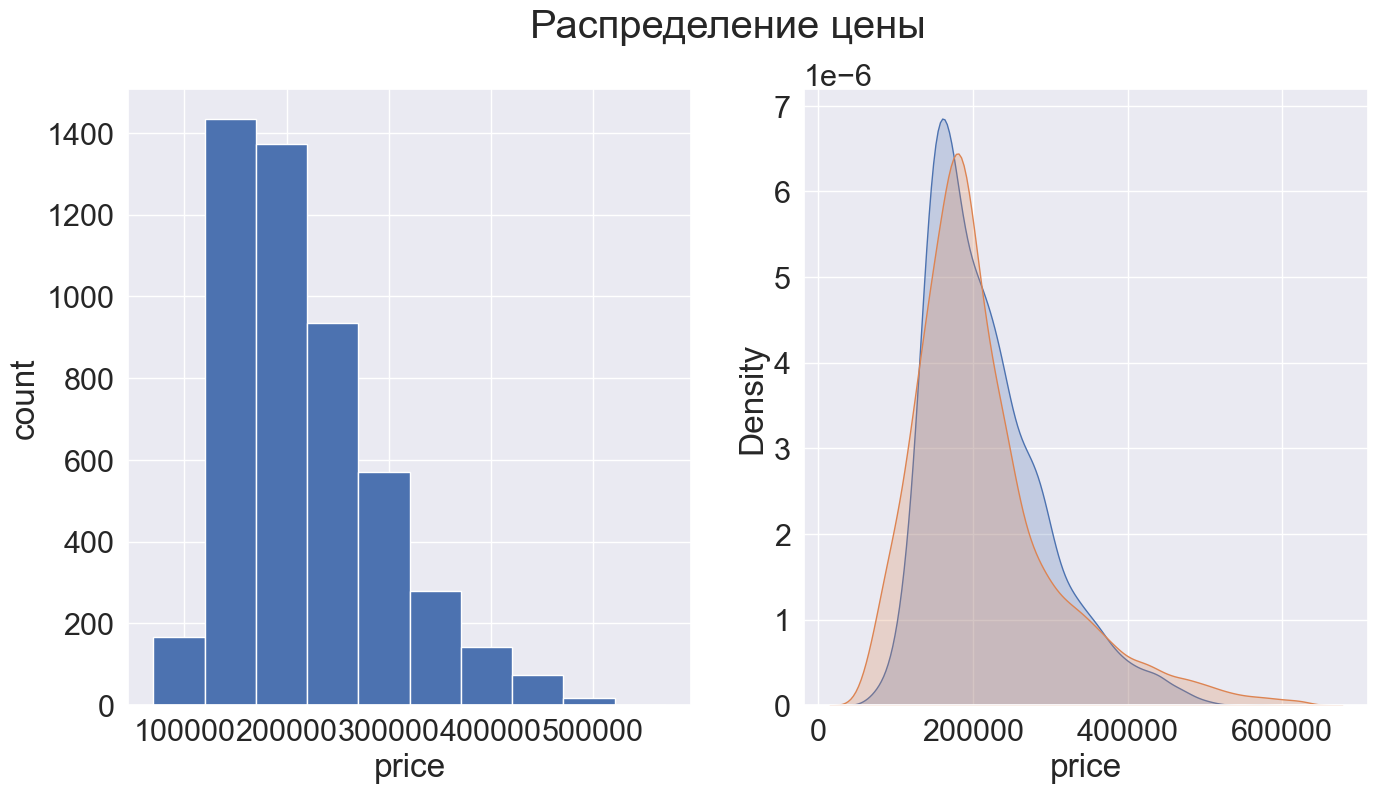

In [2488]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
test_df['Price'].hist()
plt.ylabel('count')
plt.xlabel('price')

plt.subplot(122)
sns.kdeplot(test_df['Price'], shade=True, legend=False)
sns.kdeplot(train_df['Price'], shade=True, legend=False)
plt.xlabel('price')

plt.suptitle('Распределение цены')
plt.show()

In [2489]:
test_df.to_csv(PREDICTIONS_PATH, columns=['Id', 'Price'], index=False, encoding='utf-8')